# Workshop Automatants @ CentraleSupélec - CeSIA - Partie 1

- Création : 02/2025 par [Nicolas Guillard](mailto:nicolas.guillar@securite-ia.fr) - bénévole au [CeSIA](https://www.securite-ia.fr/).
- Dernière mise à jour : 05/03/2025

Créé en adaptant et complétant le projet [Générer des noms de villes et communes françaises](https://github.com/alxndrTL/villes) par [Alexandre TL](https://www.youtube.com/@alexandretl)


## Présentation du sujet et Plan

## Indications

Les éléments de ce TP :
- le présent carnet,
  
(et ceux qui seront installés grâce au script `Installation de l'environnement de travail`),
- le répertoire `./utils` et les fichiers contenus,
- le répertoire `./weights` contenant les poids des modèles utiles et ceux produits,
- le répertoire `./images` contenant les illustrations des carnets,
- le fichier de données `./villes.txt`.

## Installation de l'environnement de travail

Le script ci-dessous est destiné à installer les éléments nécessaires au fonctionnement de ce carnet.

In [1]:
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

repo = "workshop_cs_202503"
branch = "main"
url_repo = f"https://github.com/nicolasguillard/{repo}/archive/refs/heads/{branch}.zip"
target_dir = (
  "/content"
  if IN_COLAB
  else "."
)
resources = ["utils", "weights", "images", "villes.txt"]

if not Path(f"{target_dir}/utils").exists() :
  print("=== Installation des ressources utiles à ce carnet ===")
  !wget -P {target_dir} {url_repo}
  !unzip {target_dir}/{branch}.zip -d {target_dir}
  for resource in resources:
    !mv {target_dir}/{repo}-{branch}/{resource} {target_dir}/{resource}
  !rm -rf {target_dir}/{repo}-{branch}
  !rm -f {target_dir}/{branch}.zip
  print("=== Terminé ===")

  if IN_COLAB:
    print("--- Rafraichissez au besoin la liste des fichiers à gauche si nécessaire ---")
else:
  print("Il semble que des ressources nécessaires pour ce carnet soient déjà installés :")
  for resource in resources:
    print("\t", f"./{resource}", "présent" if Path(f"{target_dir}/{resource}").exists else "absent")
  print("Pour supprimer les ressources automatiquement installées, utilisez la fonction 'remove_resources()' dans un autre bloc de code.")

def remove_resources():
  !rm -rf {target_dir}/{repo}-{branch}
  for resource in resources:
    !rm -rf {target_dir}/{resource}

Il semble que des ressources nécessaires pour ce carnet soient déjà installés :
	 ./utils présent
	 ./weights présent
	 ./images présent
	 ./villes.txt présent
Pour supprimer les ressources automatiquement installées, utilisez la fonction 'remove_resources()' dans un autre bloc de code.


## Les modules et paramétrages globaux

Tous les modules nécessaires sont importés. A moins d'un besoin spécifique, il n'y aura pas besoin de modifier le bloc de code suivant.

In [2]:
# Modules prédéfinis et tiers
import random
from collections import Counter
from typing import Tuple

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange, tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Device

Sélection du GPU selon l'environnement de travail

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Paramétrages

In [4]:
# Retirer la limite du nombre maximal de lignes affichées dans un tableau pandas
pd.set_option('display.max_rows', None) 

In [5]:
# Configurer le thème de seaborn
sns.set_theme(style="whitegrid")

In [6]:
# Paramétrer les graines aléatoires
#pth_rnd_gen_device = torch.Generator(device).manual_seed(42)
if device == "cuda":
    pth_rnd_gen_device = torch.cuda.manual_seed(42)
elif device == "mps":
    pth_rnd_gen_device = torch.mps.manual_seed(42)
pth_rnd_gen_cpu = torch.manual_seed(42)
pth_rnd_gen = pth_rnd_gen_cpu if device == "cpu" else pth_rnd_gen_device

## Exploration des données

Exécuter les différents blocs de code successivement afin de découvrir le jeu de données et son traitement destiné à produire les séquences pour le modèle de langgue basé sur un Transformer.

Certains constats vous permettront d'apprécier les résultats obtenus dans les parties suivantes, en connaissant la référence "vérité terrain".

Le jeu de données contient 36583 noms de communes françaises.

In [7]:
df = pd.read_table("./villes.txt", header=None, names=["nom"])
display(df.head(20))

,nom
0,arbignieu
1,mouilleron
2,tsingoni
3,upaix
4,margès
5,reutenbourg
6,prades-salars
7,rouffignac-de-sigoulès
8,andelarre
9,montrouveau


Affichons les premières informations structurelles :

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36583 entries, 0 to 36582
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nom     36583 non-null  object
dtypes: object(1)
memory usage: 285.9+ KB


### Quelques statistiques

#### Distribution de la longueur des noms

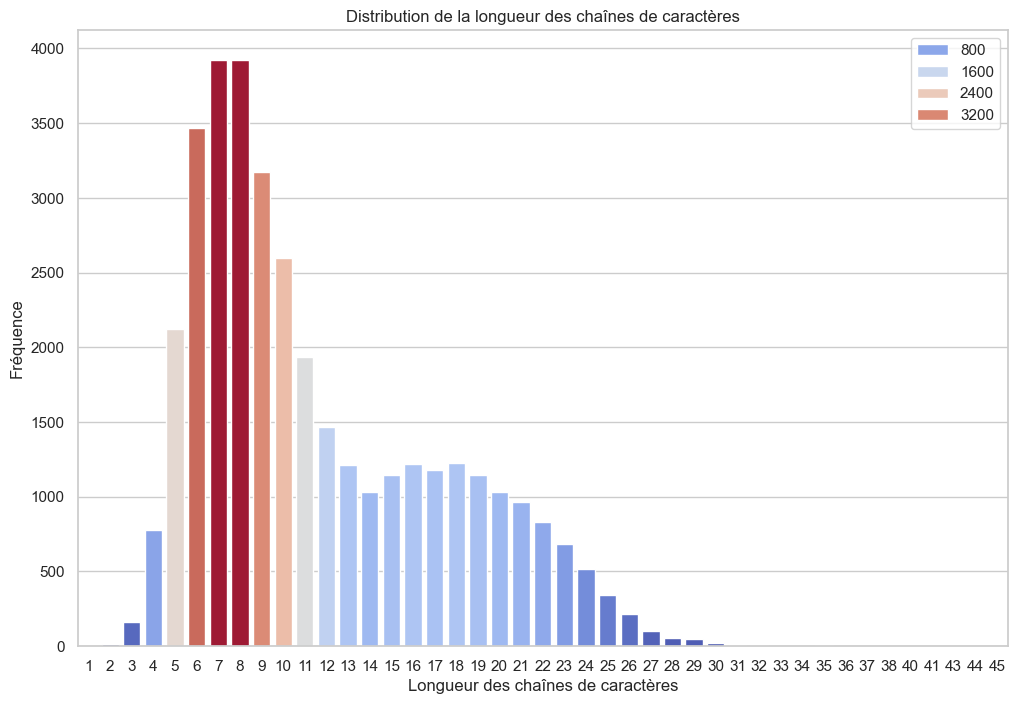

In [9]:
# Calculer la longueur des chaînes de caractères dans la colonne "nom"
df['length'] = df['nom'].apply(len)

# Afficher la distribution de la longueur des chaînes de caractères
length_distribution = df['length'].value_counts().sort_index()
#print(length_distribution)

# Afficher la distribution sous forme d'un histogramme
plt.figure(figsize=(12, 8))
sns.barplot(x=length_distribution.index, y=length_distribution.values, hue=length_distribution.values, palette="coolwarm")
plt.xlabel('Longueur des chaînes de caractères')
plt.ylabel('Fréquence')
plt.title('Distribution de la longueur des chaînes de caractères')
plt.show()

In [10]:
df['length'].describe()

count    36583.00000
mean        11.68551
std          5.78169
min          1.00000
25%          7.00000
50%         10.00000
75%         16.00000
max         45.00000
Name: length, dtype: float64

#### Fréquences des caractères dans les noms

In [11]:
# Concaténer toutes les chaînes de caractères de la colonne "nom"
all_chars = ''.join(df['nom'])

# Compter les occurrences de chaque caractère
char_counts = Counter(all_chars)

# Convertir le résultat en dataframe pour une meilleure lisibilité
char_freq_df = pd.DataFrame(
    char_counts.items(), columns=['Caractère', 'Fréquence']
    ).sort_values(by='Fréquence', ascending=False)
char_freq_df["Ratio Freq (%)"] = char_freq_df["Fréquence"] / char_freq_df["Fréquence"].sum() * 100

print("Nombre de caractères distincts :", len(char_freq_df))
display(char_freq_df)

Nombre de caractères distincts : 43


,Caractère,Fréquence,Ratio Freq (%)
6,e,46107,10.785490
0,a,37558,8.785682
5,n,32035,7.493725
10,l,30567,7.150326
12,s,30264,7.079447
1,r,30034,7.025645
3,i,28939,6.769499
17,-,26344,6.162469
9,o,22464,5.254847
7,u,21143,4.945835


#### Taux de fréquence par rapport aux (dix premières) positions dans la chaîne de caractères

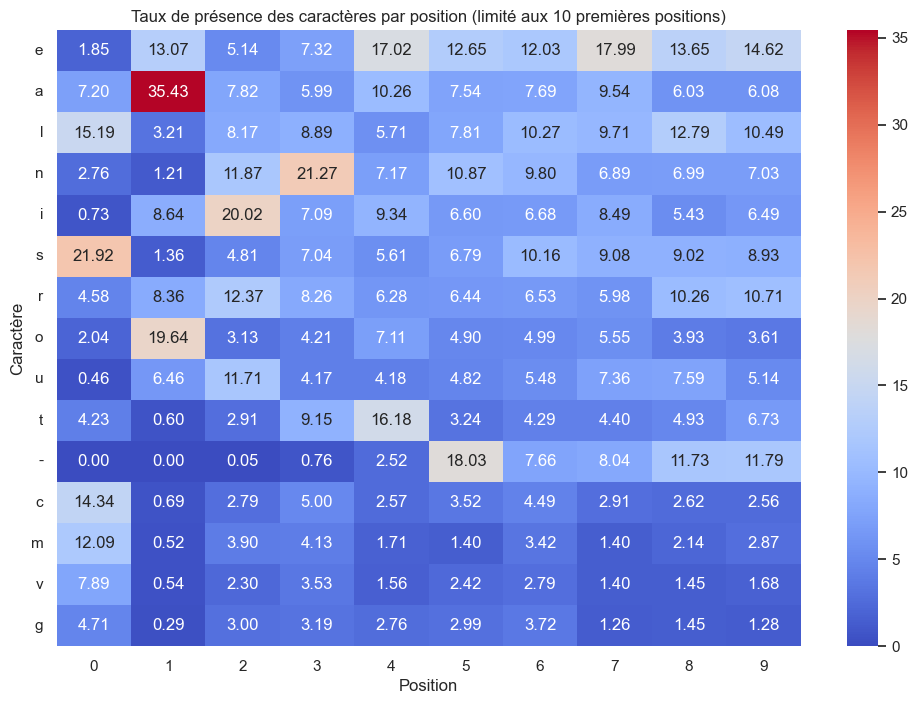

In [12]:
# Limiter la longueur des noms à 10 caractères
df['nom_limited'] = df['nom'].str[:10]

# Initialiser un dictionnaire pour stocker les fréquences des caractères par position
position_char_freq = {i: Counter() for i in range(10)}

# Remplir le dictionnaire avec les fréquences des caractères par position
for name in df['nom_limited']:
    for i, char in enumerate(name):
        position_char_freq[i][char] += 1

# Convertir le dictionnaire en dataframe pour une meilleure lisibilité
position_char_freq_df = pd.DataFrame(position_char_freq).fillna(0).astype(int)

# Limiter aux 15 premiers caractères les plus fréquents
top_chars = position_char_freq_df.sum(axis=1).sort_values(ascending=False).head(15).index
position_char_freq_df = position_char_freq_df.loc[top_chars]

# Calculer le taux de présence par position
position_char_rate_df = position_char_freq_df.div(position_char_freq_df.sum(axis=0), axis=1) * 100

# Visualiser les taux de présence avec une carte de chaleur
plt.figure(figsize=(12, 8))
sns.heatmap(position_char_rate_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.xlabel('Position')
plt.ylabel('Caractère')
plt.title('Taux de présence des caractères par position (limité aux 10 premières positions)')
plt.yticks(rotation=0)
plt.show()

#### Fréquence des composants de nom

In [13]:
# Séparer les chaînes de caractères par "-" ou " " et les concaténer
element_separator = "-' "
all_elements = ' '.join(df['nom'].str.replace(f"[{element_separator}]", " ", regex=True).values).split()

# Compter les occurrences de chaque élément
element_counts = Counter(all_elements)

# Convertir le résultat en dataframe pour une meilleure lisibilité
element_freq_df = pd.DataFrame(element_counts.items(), columns=['Élément', 'Fréquence']).sort_values(by='Fréquence', ascending=False)

print(f"Nombre total de composants distincts : {len(element_freq_df)}")
n = 15
print(f"dont {n} exemples :")
display(element_freq_df.sample(n).sort_values(by='Fréquence', ascending=False))

# Filtrer les éléments dont la fréquence est strictement supérieure à 1
element_freq_sup_1_df = element_freq_df[element_freq_df['Fréquence'] > 1]

# Afficher le nombre total d'éléments associés
print(f"Nombre total de composants présents plus d'une fois : {len(element_freq_sup_1_df)}")
n = 15
print(f"dont les {n} premiers :")
display(element_freq_sup_1_df.head(n))


Nombre total de composants distincts : 28449
dont 15 exemples :


,Élément,Fréquence
11424,escoubès,2
23632,dambelin,2
4734,courlon,2
5220,courchamps,2
24103,cel,1
12080,cléguer,1
19340,brosville,1
17358,sauvagney,1
25279,montgeroult,1
16163,vassimont,1


Nombre total de composants présents plus d'une fois : 5807
dont les 15 premiers :


,Élément,Fréquence
37,saint,4409
50,sur,2080
23,la,1868
30,le,1698
9,de,1229
101,en,971
96,lès,553
54,d,484
116,les,475
33,sainte,397


#### Combien de noms de communes sont composées ?
Quelle est la distribution du nombre de composants ?

Distribution de la fréquence du nombre de composants (en valeur) :


,count
num_components,
1,21505
2,4776
3,6810
4,3243
5,210
6,33
7,5
8,1


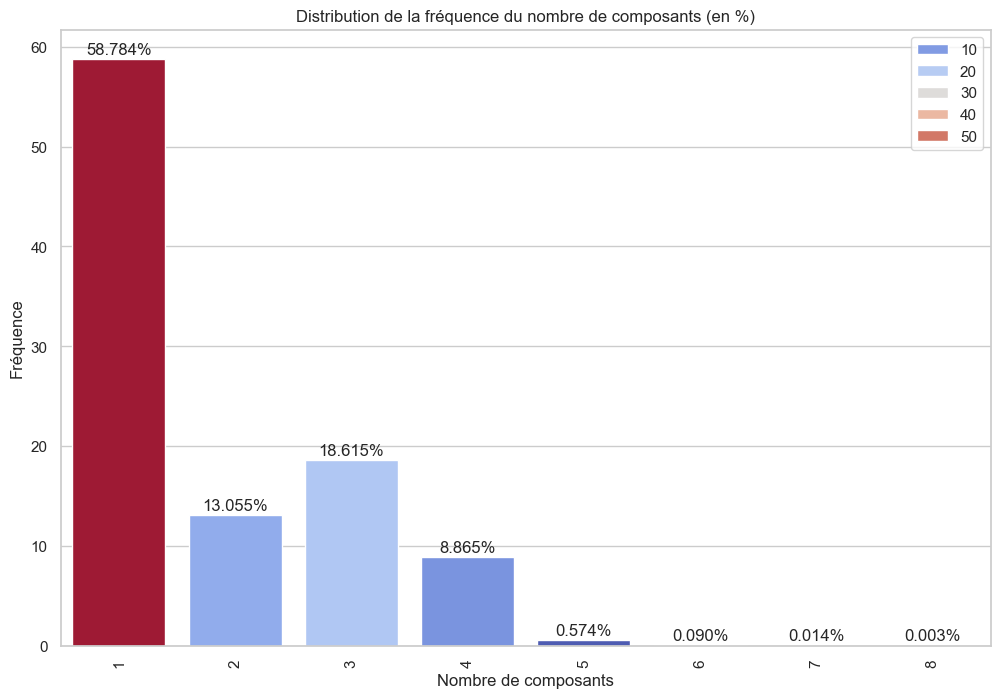

In [14]:
# Calculer le nombre de composants pour chaque nom
df['num_components'] = df['nom'].apply(lambda x: len([comp for comp in x if comp in element_separator]) + 1)

# Afficher la distribution du taux de fréquence du nombre de composants
component_distribution = df['num_components'].value_counts().sort_index()
component_distribution_rate = component_distribution / len(df) * 100
print("Distribution de la fréquence du nombre de composants (en valeur) :")
display(component_distribution.to_frame())

# Afficher la distribution sous forme d'un histogramme
plt.figure(figsize=(12, 8))
sns.barplot(x=component_distribution_rate.index, y=component_distribution_rate.values, hue=component_distribution_rate.values, palette="coolwarm")
for i in range(len(component_distribution_rate)):
    plt.text(i, component_distribution_rate.values[i] + 0.5, f'{component_distribution_rate.values[i]:.3f}%', ha='center')
plt.xlabel('Nombre de composants')
plt.ylabel('Fréquence')
plt.title('Distribution de la fréquence du nombre de composants (en %)')
plt.xticks(rotation=90)
plt.show()

## Définition de la classe dérivée Dataset et des utilitaires associés

Définition de la classe `CityNameDataset` fournissant les données pour les phases d'entrainement notamment, en créant une sous-classe dérivée de `torch.utils.data.Dataset`. Egalement création de la classe `CharTokenizer`.

> NdA : code fourni à titre informatif.

Au préalable, définition de jetons de contrôle de séquence.

In [15]:
SOS = "<SOS>" # Start Of Sequence
EOS = "<EOS>" # End Of Sequence
PAD = "<PAD>" # Padding

In [16]:
class CharTokenizer():
    def __init__(self, corpus: list[str]) -> None:
        self.special_tokens =  [PAD, SOS, EOS] # PAD en premier pour indice 0

         # liste des différents caractères distincts
        chars = sorted(list(set(''.join(corpus))))
        # ajout des trois jetons de contrôle
        chars = self.special_tokens + chars
        # tables de correspondances
        self.char_to_int = {}
        self.int_to_char = {}

        # indexation des tables de correspondances
        for (c, i) in tqdm(
            zip(chars, range(len(chars))),
            desc="creating vocabulary",
            total=len(chars)
            ):
            self.char_to_int[c] = i
            self.int_to_char[i] = c

    def __call__(self, string: str) -> list[int]:
        return self.to_idx(string)
            
    def vocabulary_size(self) -> int:
        return len(self.char_to_int)
    
    def to_idx(self, sequence: str) -> list[int]:
        """
        Translate a sequence of chars to its conterparts of indexes in the vocabulary
        """
        return [self.char_to_int[c] for c in sequence]
    
    def to_tokens(self, sequence: list[int]) -> list[str]:
        """
        Translate a sequence of indexes to its conterparts of chars in the vocabulary
        """
        return [self.int_to_char[i] for i in sequence]
    
    def to_string(self, sequence: list[int]) -> str:
        """
        Return the string corresponding to the sequence of indexes in the vocabulary
        """
        return "".join([self.int_to_char[i] for i in sequence if i > 2])
    


class CityNameDataset(Dataset):
    def __init__(self, names: list[str], tokenizer: CharTokenizer) -> None:
        """
        Args:
            - names : collection of string
            - vocabulary : maps of "char to index" and "index to char" based on names
        """
        super().__init__()

        self.tokenizer = tokenizer
        
        # création des séquences encodées
        num_sequences = len(names)
        self.max_len = max([len(name) for name in names]) + 2 # <SOS> et <EOS>
        self.X = torch.zeros((num_sequences, self.max_len), dtype=torch.int32)
        for i, name in tqdm(enumerate(names), total=num_sequences, desc="creatind dataset"):
            # encodage de la séquence : "SOS s e q u e n c e EPS PAD PAD ... PAD"
            self.X[i] = torch.tensor(
                self.tokenizer([SOS]) +
                self.tokenizer(name) +
                self.tokenizer([EOS]) +
                self.tokenizer([PAD] * (self.max_len - len(name) - 2))
            )
            
    def __len__(self):
        """
        """
        return self.X.size(0)

    def __getitem__(self, idx: int):
        """
        """
        return self.X[idx, :-1], self.X[idx, 1:]


def get_datasets(
        filename: str,
        split_rate: float = 0.9
        ) -> Tuple[CityNameDataset, CityNameDataset, CharTokenizer, int]:
    """
    Return train and test datasets, and the max length in the processed string collection

    Args:
        - filename (str) : path and file name of string data
        - split_rate (float) : rate of the split of the train data, in [0.; 1.]
    
    Returns:
        - train_dataset, test_dataset, max_len (Tuple[CityNameDataset, CityNameDataset, int]) : 
            dataset for train, dataset for test, max length in the processed string collection
    """
    # chargement des données
    file = open(filename)
    raws = file.read()
    names = raws.replace('\n', ',').split(',')
    # mise à l'écart des villes avec un nom de longueur inférieure à 3
    # et détermination de la plus grande longueur
    names_ = []
    max_len = 0
    for n in names:
        if len(names) > 2:
            names_.append(n)
            max_len = max(max_len, len(n))

    # création du tokenizer
    tokenizer = CharTokenizer(names_)

    # mélange de l'ensemble des noms
    names_ = random.sample(names_, len(names_))
    # index de séparation train/val
    n_split = int(split_rate * len(names_))
    
    train_dataset = CityNameDataset(names_[:n_split], tokenizer)
    test_dataset = CityNameDataset(names_[n_split:], tokenizer)

    return train_dataset, test_dataset, tokenizer, max_len

Tests de la classe et des utilisataires.

In [17]:
train_dataset, test_dataset, tokenizer, max_len = get_datasets("./villes.txt")

creating vocabulary:   0%|          | 0/46 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/32926 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/3659 [00:00<?, ?it/s]

In [18]:
print("Longueur de la plus longue séquence d'un nom de commune", max_len)

Longueur de la plus longue séquence d'un nom de commune 45


In [19]:
tokenizer("test")

[25, 10, 24, 25]

Différents affichages de séquence

In [20]:
X, y = train_dataset[1] # Get a dataset item (index = 1), the tuple X, y
print("X (indexes):", X)
print("y (indexes) :", y, end="\n\n")

print("X (chars):", tokenizer.to_tokens(X.tolist()))
print("y (chars):", tokenizer.to_tokens(y.tolist()), end="\n\n")

print("X (string):", tokenizer.to_string(X.tolist()))
print("y (string):", tokenizer.to_string(y.tolist()), end="\n\n")

X (indexes): tensor([ 1, 27, 14, 19, 10, 26, 14, 17,  5, 24,  6, 14, 19, 25,  5, 11, 14, 23,
        18, 14, 19,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)
y (indexes) : tensor([27, 14, 19, 10, 26, 14, 17,  5, 24,  6, 14, 19, 25,  5, 11, 14, 23, 18,
        14, 19,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)

X (chars): ['<SOS>', 'v', 'i', 'n', 'e', 'u', 'i', 'l', '-', 's', 'a', 'i', 'n', 't', '-', 'f', 'i', 'r', 'm', 'i', 'n', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
y (chars): ['v', 'i', 'n', 'e', 'u', 'i', 'l', '-', 's', 'a', 'i', 'n', 't', '-', 'f', 'i', 'r', 'm', 'i', 'n', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

Utilisation de la classe `torch.utils.data.DataLoader` se basant sur un dataset de classe `CityNameDataset`.

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [22]:
batch_X, batch_y = next(iter(train_dataloader))
print("Dimensions du batch", batch_X.size(), end="\n\n")

X = batch_X[14]
y = batch_y[14]

print("X (indexes):", X)
print("y (indexes) :", y, end="\n\n")

print("X (chars):", tokenizer.to_tokens(X.tolist()))
print("y (chars):", tokenizer.to_tokens(y.tolist()), end="\n\n")

print("X (string):", tokenizer.to_string(X.tolist()))
print("y (string):", tokenizer.to_string(y.tolist()), end="\n\n")

Dimensions du batch torch.Size([64, 46])

X (indexes): tensor([ 1, 21, 20, 26, 30,  9, 23,  6, 12, 26, 14, 19,  2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)
y (indexes) : tensor([21, 20, 26, 30,  9, 23,  6, 12, 26, 14, 19,  2,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)

X (chars): ['<SOS>', 'p', 'o', 'u', 'y', 'd', 'r', 'a', 'g', 'u', 'i', 'n', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
y (chars): ['p', 'o', 'u', 'y', 'd', 'r', 'a', 'g', 'u', 'i', 'n', '<EOS>', '<PAD>', '<PAD>'